Importing libraries

In [10]:
#introducing libraries
!pip install numpy scipy pandas>1.0 matplotlib lmfit colour

In [11]:
#calling up libraries
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from datetime import timedelta
from lmfit.models import LorentzianModel
import statistics
from matplotlib.collections import LineCollection
from scipy.signal import argrelmax

Importing data from google drive folder, sorting each into absorbance, spectroscope runs, and general spectroscope data.

In [12]:
#import CSV data from drive
from google.colab import drive
import glob
import os
drive.mount('drive', force_remount=True)
folder = "/content/drive/MyDrive/p3ht-pcbm spectra for upload"
all_files = glob.glob(os.path.join(folder, '*.csv'))
Spec_data = {}
Sorb_data = {}
Irr_data = {}
titles = []


Mounted at drive


In [13]:


for filename in all_files:
  #Simplify name
  new_name = filename.replace(".csv", "").replace("/content/drive/MyDrive/p3ht-pcbm spectra for upload/","")
  #import data
  df = pd.read_csv(filename, sep=',', header=0)
  #Some cleaning
  df.columns = ['Wavelength [nm]', 'Absorbance']
  df=df.set_index('Wavelength [nm]')
  df=df.sort_index()
  print(df)
  Irr_data[new_name] = df
  #change strings to numbers

  titles.append(new_name)
  Spec_data[new_name] = df


Irr_data






                 Absorbance
Wavelength [nm]            
413.772381         0.424085
421.543435         0.451956
428.204339         0.482979
433.385042         0.514255
438.195694         0.545572
...                     ...
766.800279        -0.002022
774.941384        -0.002247
783.082489        -0.002472
791.223593        -0.000895
796.034246        -0.000619

[68 rows x 1 columns]
                 Absorbance
Wavelength [nm]            
404.151075         0.238903
411.922130         0.269053
418.953084         0.296874
425.243937         0.326141
431.164740         0.357130
...                     ...
722.527472         0.012270
734.065934         0.010225
753.296703         0.006135
775.274725        -0.004090
795.054945        -0.004090

[68 rows x 1 columns]
                 Absorbance
Wavelength [nm]            
272.978791         0.293628
283.590697         0.250897
298.448857         0.199501
314.367462         0.139618
327.112189         0.147329
347.824423         0.171446
37

{'P3HT NPs solution (Clafton et al. 2013)':                  Absorbance
 Wavelength [nm]            
 272.978791         0.293628
 283.590697         0.250897
 298.448857         0.199501
 314.367462         0.139618
 327.112189         0.147329
 347.824423         0.171446
 370.667986         0.237578
 387.669408         0.295612
 413.707729         0.412127
 440.816935         0.579143
 456.771336         0.721505
 470.066421         0.838736
 483.889491         0.939083
 499.823011         0.963469
 516.803552         0.903526
 527.406509         0.810234
 538.013940         0.742222
 550.212785         0.665694
 563.989619         0.504808
 574.591085         0.403088
 586.786947         0.309707
 600.584662         0.266797
 614.907379         0.190149
 629.228605         0.105075
 641.956926         0.020090,
 'P3HT bulk film (Tsoi et al, 2011)':                  Absorbance
 Wavelength [nm]            
 404.151075         0.238903
 411.922130         0.269053
 418.953084         

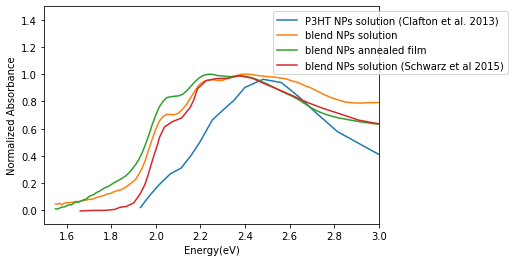

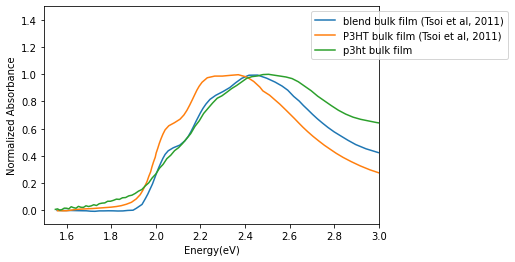

In [19]:
for name in Irr_data:
  if 'NPs' in name:
    x = 1240/np.asarray(Irr_data[name].index)
    y = np.asarray(Irr_data[name]['Absorbance'])
    plt.plot(x, y, label=name)

plt.legend(bbox_to_anchor=(1.4,1))
plt.xlim(1.5, 3)
plt.ylim(-0.1,1.5)
plt.xlabel('Energy(eV)')
plt.ylabel('Normalized Absorbance')
plt.show()

for name in Irr_data:
  if 'bulk' in name:
    x = 1240/np.asarray(Irr_data[name].index)
    y = np.asarray(Irr_data[name]['Absorbance'])
    plt.plot(x, y, label=name)

plt.legend(bbox_to_anchor=(1.4,1))
plt.xlim(1.5, 3)
plt.ylim(-0.1,1.5)
plt.xlabel('Energy(eV)')
plt.ylabel('Normalized Absorbance')
plt.show()


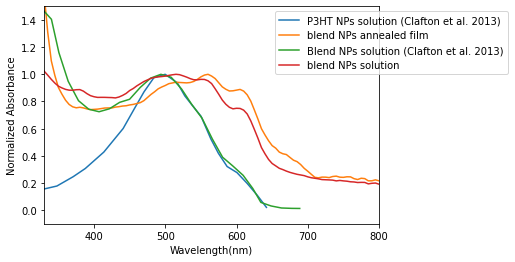

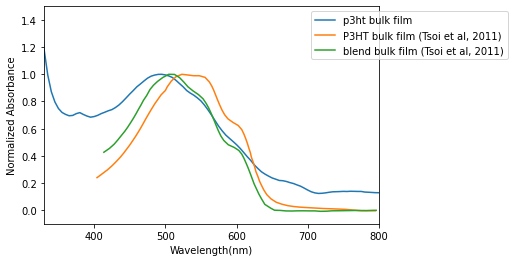

In [ ]:
#Normalize
for name in Irr_data:
  df = Irr_data[name]
  df_short = df[df.index.to_series().between(400,800)]
  m_val = df_short.max()
  Irr_data[name] = df/m_val

for name in Irr_data:
  if 'NPs' in name:
    x = np.asarray(Irr_data[name].index)
    y = np.asarray(Irr_data[name]['Absorbance'])
    plt.plot(x, y, label=name)

plt.legend(bbox_to_anchor=(1.4,1))
plt.xlim(330, 800)
plt.ylim(-0.1,1.5)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Normalized Absorbance')
plt.show()



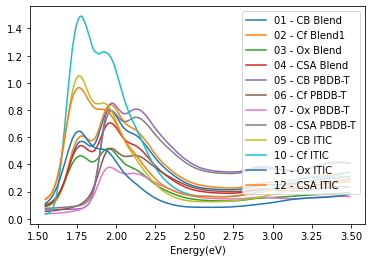

In [ ]:
full_data = full_data[full_data.index <3.5]
data_corrected = pd.DataFrame()
bgrd = full_data['quartz']
for name in full_data.columns[2:]:
  data_corrected[name] = full_data[name] - bgrd
data_corrected.plot()
  

[0.88211698 0.32178765 0.4022906 ]


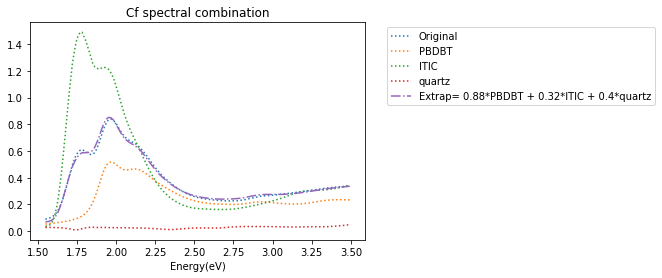

In [ ]:
#https://stackoverflow.com/questions/54890415/scipy-optimize-minimize-using-dataframe
import scipy.optimize as opt
#Add composition spectra in most accurate proportions to produce the blend spectrum observed
def main(df):
    x0 = [0.5,0.5, 0.2]
    res = opt.minimize(fun=obj, x0=np.array(x0), args=(df), method="Nelder-Mead")
    return res

def obj(x, df):
    #maybe use a global variable to get the dataframe or via args
    sumSquares = np.sum((df["Y"] - (x[0]*df["X1"] + x[1]*df["X2"] + x[2]*df["X3"]))**2)
    return sumSquares

def dataset(i, ds):
  df = pd.DataFrame()
  for name in ds.columns:
    if ('Blend' in name) and (i in name):
      df['Y'] = ds[name]
    if ('PBDB' in name) and (i in name):
      df['X1'] = ds[name]
    if ('ITIC' in name) and (i in name):
      df['X2'] = ds[name]
    df['X3'] = full_data['quartz']
  return df   

def graph_check(i, ds):
  df = pd.DataFrame()
  for name in ds.columns:
    if ('Blend' in name) and (i in name):
      df['Original'] = ds[name]
    if ('PBDB' in name) and (i in name):
      df['PBDBT'] = ds[name]
    if ('ITIC' in name) and (i in name):
      df['ITIC'] = ds[name]
  df['quartz'] = full_data['quartz']
  a = main(dataset(i, ds))['x'][0]
  b = main(dataset(i, ds))['x'][1]
  c = main(dataset(i, ds))['x'][2]
  df['Extrap= '+str(np.around(a,2))+'*PBDBT + '+str(np.around(b,2))+'*ITIC + ' + str(np.around(c,2)) + "*quartz"] = a*df['PBDBT'] + b*df['ITIC'] + c*df['quartz']
  df.plot(title=i+' spectral combination', style=[':',':',':', ':', '-.'])
  plt.legend(bbox_to_anchor=(1.05,1))
  print(main(dataset(i, ds))['x'])

new_try = data_corrected[data_corrected.index < 2.5] 
graph_check('Cf', data_corrected)

[ 0.37127299  0.48104302 -0.57558625]


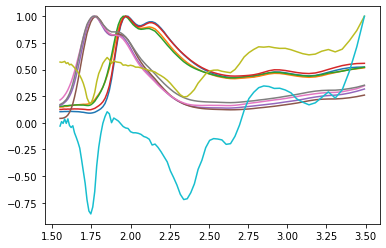

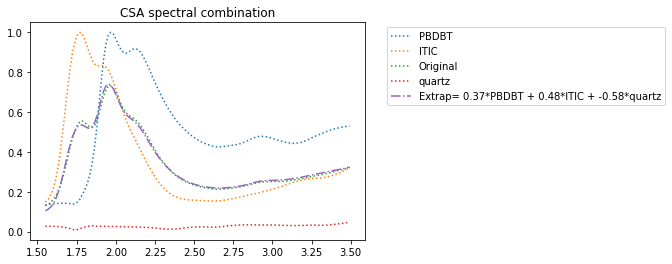

In [ ]:
#Compare normalized version of all material spectra
mats = ['PBDB-T', 'ITIC', 'quartz']
def normal_plot(data, name):
  m = data.max()
  norm = data/m
  plt.plot(norm)
  return norm

#They look a little different, what if we use average as basis spectra?
def avg_norms(mat, data=full_data):
    frame = pd.DataFrame()
    for name in data.columns:
      if mat in name:
        norm = normal_plot(data[name], name)
        frame = frame.append(norm)
    return frame.mean()
frames = {}
for mat in mats:
  frames[mat] = avg_norms(mat)
frames
def norm_basis(lab,data=full_data, frames=frames):
  basis = pd.DataFrame()
  for frame in frames:
    basis[lab+' '+frame] = frames[frame]
  for name in data.columns:
    if (lab in name) and ('Blend' in name): 
      basis[lab+' Blend'] = data[name]
  return basis

def add_test(bar):
  graph_check(bar, norm_basis(bar))

add_test('CSA')



In [ ]:
#set apart different data sets
titles = ['Chlorobenzene', 'Chloroform', 'o-Xylene', 'CSA']
frames = {}
for i in range(4):
  frames[titles[i]] = full_data.iloc[:, (i+3)::4].astype(float)
  frames[titles[i]] = frames[titles[i]].set_index(indx.astype(float))
frames

{'CSA':                  05 - CB PBDB-T  09 - CB ITIC
 Wavelength (nm)                              
 800.004883             0.091558      0.173582
 794.982849             0.091730      0.181649
 789.985413             0.092279      0.190261
 785.013000             0.093126      0.203989
 779.995972             0.093014      0.218257
 ...                         ...           ...
 219.996399             4.511799      3.628136
 214.989853             3.725582      3.998365
 209.981247             4.188190      3.898090
 205.010025             3.992398      3.991359
 199.997391             3.504264      3.760888
 
 [121 rows x 2 columns],
 'Chlorobenzene':                  02 - Cf Blend1  06 - Cf PBDB-T  10 - Cf ITIC
 Wavelength (nm)                                              
 800.004883             0.116364        0.080499      0.062734
 794.982849             0.118908        0.080839      0.063971
 789.985413             0.121890        0.081076      0.066813
 785.013000            

Plot same materials with different solvents on a graph

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

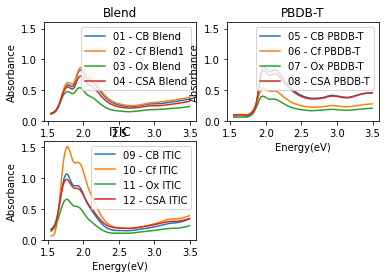

In [ ]:
for name in full_data.columns:
  work_with = full_data[full_data.index < 3.5]
  if "Blend" in name:
    plt.subplot(2,2,1)
    plt.title('Blend')
  elif "PBDB-T" in name:
    plt.subplot(2,2,2)
    plt.title('PBDB-T')
  elif "ITIC" in name:
    plt.subplot(2,2,3)
    plt.title('ITIC')
  plt.plot(np.asarray(work_with.index), np.asarray(work_with[name]), label = name)
  plt.rcParams["figure.figsize"] = (20,10)
  plt.ylim(0,1.6)
  plt.ylabel('Absorbance')
  plt.xlabel('Energy(eV)')
  plt.legend()
plt.show()


                 01 - CB Blend  05 - CB PBDB-T  09 - CB ITIC
Wavelength (nm)                                             
800.004883            0.125256        0.091558      0.173582
794.982849            0.127833        0.091730      0.181649
789.985413            0.132434        0.092279      0.190261
785.013000            0.137764        0.093126      0.203989
779.995972            0.143895        0.093014      0.218257
...                        ...             ...           ...
369.988800            0.330108        0.443140      0.284308
364.990570            0.338319        0.452404      0.297284
359.988739            0.347838        0.456759      0.315343
354.983215            0.358418        0.458095      0.337551
350.013061            0.374409        0.459749      0.370588

[91 rows x 3 columns]
                 02 - Cf Blend1  06 - Cf PBDB-T  10 - Cf ITIC
Wavelength (nm)                                              
800.004883             0.116364        0.080499      0.06273

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

                 03 - Ox Blend  07 - Ox PBDB-T  11 - Ox ITIC
Wavelength (nm)                                             
800.004883            0.116480        0.062362      0.140640
794.982849            0.119541        0.063121      0.147947
789.985413            0.126540        0.063059      0.157688
785.013000            0.133156        0.065027      0.170296
779.995972            0.142991        0.064940      0.185154
...                        ...             ...           ...
369.988800            0.215300        0.195890      0.191792
364.990570            0.221973        0.201354      0.200426
359.988739            0.229944        0.206135      0.210146
354.983215            0.240685        0.210865      0.227967
350.013061            0.256293        0.219143      0.250877

[91 rows x 3 columns]
                 04 - CSA Blend  08 - CSA PBDB-T  12 - CSA ITIC
Wavelength (nm)                                                
800.004883             0.128507         0.102968       0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

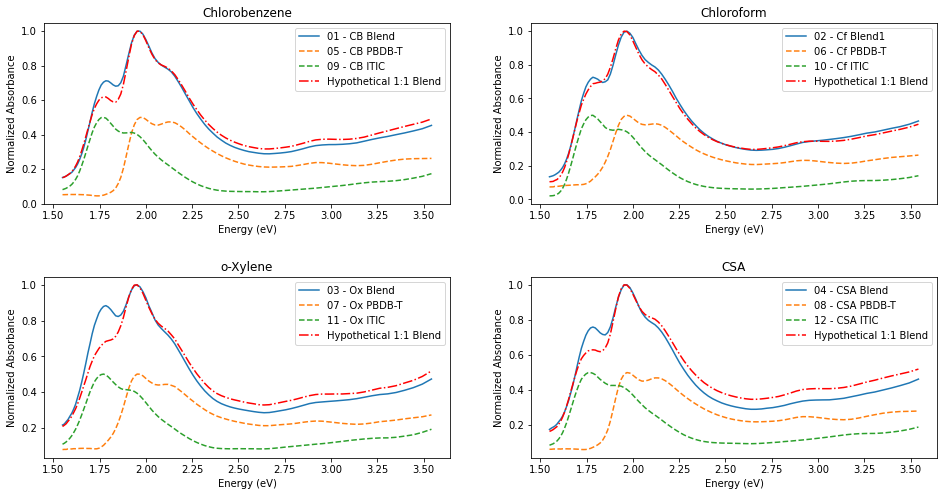

In [ ]:
#Removing noisy data
fig = plt.figure()
plt.subplots_adjust(hspace=0.4)
for i in range(4):
  data_to_work_with = frames[titles[i]][frames[titles[i]].index <= 1239.842/350 ]
  
  print(data_to_work_with)
#Normalization based on peak
  data_to_work_with.index = 1239.84198/data_to_work_with.index
  for name in data_to_work_with:
    if int(name[0:2]) <=4:
      val = data_to_work_with[name].max()
    else:
      val = 2*data_to_work_with[name].max()

    data_to_work_with[name] = data_to_work_with[name]/val
  axn = fig.add_subplot(2,2,(i+1))
  data_to_work_with['Hypothetical 1:1 Blend'] = (data_to_work_with.iloc[:,1] + data_to_work_with.iloc[:,2])
  val2 = data_to_work_with['Hypothetical 1:1 Blend'].max()
  data_to_work_with['Hypothetical 1:1 Blend'] = data_to_work_with['Hypothetical 1:1 Blend']/val2
  data_to_work_with.plot(xlabel="Energy (eV)", ylabel='Normalized Absorbance', title=titles[i], style = ['-', '--', '--', 'r-.'], ax=axn, figsize=(16,8))

plt.show()

              quartz   quartz1  ...  11 - Ox ITIC  12 - CSA ITIC
Energy(eV)                      ...                             
1.549793    0.027107 -0.000639  ...      0.140640       0.167800
1.559583    0.026949  0.000244  ...      0.147947       0.176033
1.569449    0.027127 -0.000108  ...      0.157688       0.184019
1.579390    0.027396  0.000749  ...      0.170296       0.198187
1.589549    0.026447 -0.000104  ...      0.185154       0.213392
...              ...       ...  ...           ...            ...
3.306393    0.031631  0.004860  ...      0.187487       0.299212
3.351026    0.032836  0.006475  ...      0.191792       0.304186
3.396915    0.036622  0.010123  ...      0.200426       0.313749
3.444113    0.041160  0.014906  ...      0.210146       0.326439
3.492678    0.047519  0.020895  ...      0.227967       0.344781

[90 rows x 14 columns]
Index(['1.5794', '1.5998', '1.6207', '1.8505', '1.8929', '1.968', '1.9998',
       '2.5564', '2.8178', '2.8833', '2.9876', '3.2626'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instanc

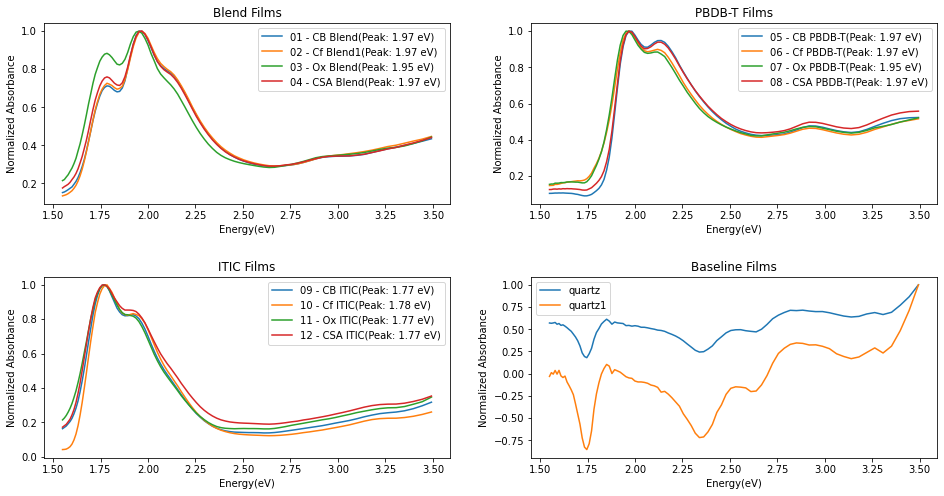

In [ ]:
clean_data = full_data[full_data.index<3.5]
fig = plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.4)
print(clean_data)
norm_data = pd.DataFrame()
#normalize all data
for name in clean_data.columns:
  val = clean_data[name].max()
  Ep = clean_data[name].idxmax()
  norm_data[name] = clean_data[name]/val
  if "Blend" in name:
    plt.subplot(2,2,1)
    plt.plot(np.asarray(norm_data.index), np.asarray(norm_data[name]), label=name+"(Peak: "+str(np.around(Ep,2))+" eV)")
    plt.xlabel('Energy(eV)')
    plt.ylabel('Normalized Absorbance')
    plt.title('Blend Films')
  elif "PBDB-T" in name:
    plt.subplot(2,2,2)
    plt.plot(np.asarray(norm_data.index), np.asarray(norm_data[name]), label=name+"(Peak: "+str(np.around(Ep,2))+" eV)")
    plt.xlabel('Energy(eV)')
    plt.ylabel('Normalized Absorbance')
    plt.title('PBDB-T Films')
  elif "ITIC" in name:
    plt.subplot(2,2,3)
    plt.plot(np.asarray(norm_data.index), np.asarray(norm_data[name]),label = name+"(Peak: "+str(np.around(Ep,2))+" eV)")
    plt.xlabel('Energy(eV)')
    plt.ylabel('Normalized Absorbance')
    plt.title('ITIC Films')
  else:
    plt.subplot(2,2,4)
    plt.plot(np.asarray(norm_data.index), np.asarray(norm_data[name]), label=name)
    plt.xlabel('Energy(eV)')
    plt.ylabel('Normalized Absorbance')
    plt.title('Baseline Films')
  print(np.around(norm_data.index[argrelmax(np.asarray(norm_data[name]), axis=0, order=1)], 4).astype(str))
  plt.legend()
plt.show()

In [ ]:
full_data.columns

Index(['quartz', 'quartz1', '01 - CB Blend After', '01 - CB Blend',
       '02 - Cf Blend1', '03 - Ox Blend', '04 - CSA Blend', '05 - CB PBDB-T',
       '06 - Cf PBDB-T', '07 - Ox PBDB-T', '08 - CSA PBDB-T', '09 - CB ITIC',
       '10 - Cf ITIC', '11 - Ox ITIC', '12 - CSA ITIC'],
      dtype='object')